In [ ]:

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from support import load_dataset
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

# -----------------------------
#        INPUT PARAMETERS
# -----------------------------
# Choose one of: "random" or "TPE"
SEARCH_METHOD = "TPE"    # ← change to "TPE" if you want TPE Search

# Random seed
SEED = 18

# Cross-Validation (CV) settings
CV_FOLDS  = 5
CV_EPOCHS = 30

# Optuna hyperparameter tuning settings
OPTUNA_TRIALS = 50

# Persistent storage URL (one file per method)
STORAGE_URL = f"sqlite:///{SEARCH_METHOD}_hparam_results.db"

# Final model training settings
NUM_EPOCHS_FINAL = 30

# Hyperparameter search ranges (you can adjust these if desired)
HP_LR_LOW    = 1e-5
HP_LR_HIGH   = 1e-2
HP_DROPOUT_LOW  = 0.1
HP_DROPOUT_HIGH = 0.7
HP_BATCH_OPTIONS   = [16, 32, 64]
HP_NUM_FILTERS_OPTS = [16, 32, 48, 64]

# Filenames for saved plots and model checkpoints
VAL_CURVES_FILENAME      = "validation_curves.png"
VAL_LOSS_CURVES_FILENAME = "validation_loss_curves.png"
# When saving the final retrained model:
MODEL_FILENAME = f"cnn_{SEARCH_METHOD}_best.pth"

# Base directory for plots (one per SEARCH_METHOD)
PLOTS_DIR = f"plots/{SEARCH_METHOD}"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Other constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
#        END PARAMETERS
# -----------------------------

# Set seed for reproducibility
def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

print(f"[Cell 0] Device in use: {DEVICE}")
print("[Cell 0] Loading datasets…")
train_dataset, test_dataset = load_dataset()
print(f"[Cell 0] Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")

# Define CNN (single definition)
class CNN(nn.Module):
    def __init__(self, num_filters: int = 16, dropout: float = 0.5):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Dynamically compute flattened size (input assumed 60 × 30)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 60, 30)
            out = self.features(dummy)
            flat_size = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training / evaluation helpers
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
    return correct / len(loader.dataset)

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            count += inputs.size(0)
    return total_loss / count

# Train a model for multiple epochs (used later for final retraining)
def train_full_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs: int):
    train_accs = []
    train_losses = []
    test_accs = []
    test_losses = []
    for epoch in range(1, num_epochs + 1):
        # Train on training set
        model.train()
        running_loss = 0.0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc  = correct / len(train_loader.dataset)

        # Evaluate on test set
        model.eval()
        total_loss = 0.0
        correct = 0
        count = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                count += inputs.size(0)
        test_loss = total_loss / count
        test_acc  = correct / count

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(
            f"[Final] Epoch {epoch:02d}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}"
        )
    return train_losses, train_accs, test_losses, test_accs

# Plot learning curves (accuracy + loss) and save under plots/{SEARCH_METHOD}/…
def plot_learning_curves(
    epochs,
    train_accs,
    test_accs,
    train_losses,
    test_losses,
    acc_title: str,
    loss_title: str,
    acc_filepath: str,
    loss_filepath: str
):
    # Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accs, marker='o', label="Train Accuracy")
    plt.plot(epochs, test_accs, marker='s', label="Test Accuracy")
    if train_accs:
        best_train_idx = int(np.argmax(train_accs))
        best_train_val = max(train_accs)
        plt.scatter(epochs[best_train_idx], best_train_val, color='blue')
        plt.text(epochs[best_train_idx], best_train_val + 0.01,
                 f"Max Train Acc: {best_train_val:.2f}", color='blue')
    if test_accs:
        best_test_idx = int(np.argmax(test_accs))
        best_test_val = max(test_accs)
        plt.scatter(epochs[best_test_idx], best_test_val, color='orange')
        plt.text(epochs[best_test_idx], best_test_val + 0.01,
                 f"Max Test Acc: {best_test_val:.2f}", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(acc_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_filepath, dpi=300)
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, marker='o', label="Train Loss")
    plt.plot(epochs, test_losses, marker='s', label="Test Loss")
    if train_losses:
        best_train_loss_idx = int(np.argmin(train_losses))
        best_train_loss_val = min(train_losses)
        plt.scatter(epochs[best_train_loss_idx], best_train_loss_val, color='blue')
        plt.text(epochs[best_train_loss_idx], best_train_loss_val + 0.01,
                 f"Min Train Loss: {best_train_loss_val:.2f}", color='blue')
    if test_losses:
        best_test_loss_idx = int(np.argmin(test_losses))
        best_test_loss_val = min(test_losses)
        plt.scatter(epochs[best_test_loss_idx], best_test_loss_val, color='orange')
        plt.text(epochs[best_test_loss_idx], best_test_loss_val + 0.01,
                 f"Min Test Loss: {best_test_loss_val:.2f}", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(loss_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(loss_filepath, dpi=300)
    plt.show()


[Cell 0] Device in use: cuda
[Cell 0] Loading datasets…
[Cell 0] Train set size: 136, Test set size: 34


In [ ]:
# Cell 1: Run a single hyperparameter search (“random” or “TPE”) and save trials to SQLite

print(f"[Cell 1] Starting {SEARCH_METHOD.upper()} Search hyperparameter tuning…")

# Precompute labels and indices for StratifiedKFold
labels_list = [int(train_dataset[i][1]) for i in range(len(train_dataset))]
all_indices = list(range(len(train_dataset)))

def objective(trial):
    # Sample hyperparameters within the ranges defined in Cell 0
    lr            = trial.suggest_float("lr", HP_LR_LOW, HP_LR_HIGH, log=True)
    dropout       = trial.suggest_float("dropout", HP_DROPOUT_LOW, HP_DROPOUT_HIGH)
    optimizer_name= trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size    = trial.suggest_categorical("batch_size", HP_BATCH_OPTIONS)
    num_filters   = trial.suggest_categorical("num_filters", HP_NUM_FILTERS_OPTS)

    print(
        f"[Trial {trial.number}] lr={lr:.2e}, dropout={dropout:.2f}, "
        f"opt={optimizer_name}, batch_size={batch_size}, num_filters={num_filters}"
    )

    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    fold_accuracies = []
    fold_losses     = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_indices, labels_list), start=1):
        train_sub = Subset(train_dataset, train_idx)
        val_sub   = Subset(train_dataset, val_idx)

        train_loader = DataLoader(
            train_sub,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_sub,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        model     = CNN(num_filters=num_filters, dropout=dropout).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = (
            optim.Adam(model.parameters(), lr=lr)
            if optimizer_name == "Adam"
            else optim.SGD(model.parameters(), lr=lr)
        )

        # Train for CV_EPOCHS on this fold
        for epoch in range(1, CV_EPOCHS + 1):
            train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
            if epoch == CV_EPOCHS or epoch % 5 == 0:
                print(f"    [Fold {fold_idx}] Epoch {epoch}/{CV_EPOCHS}")

        # Evaluate on validation fold
        total_loss = 0.0
        correct    = 0
        total      = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += inputs.size(0)

        mean_loss_fold = total_loss / total
        acc_fold       = correct / total

        print(
            f"    → Fold {fold_idx} results: Acc={acc_fold:.4f}, Loss={mean_loss_fold:.4f}"
        )
        fold_losses.append(mean_loss_fold)
        fold_accuracies.append(acc_fold)

    mean_cv_acc  = float(np.mean(fold_accuracies))
    mean_cv_loss = float(np.mean(fold_losses))
    trial.set_user_attr("mean_cv_loss", mean_cv_loss)
    trial.set_user_attr("fold_accuracies", fold_accuracies)
    trial.set_user_attr("fold_losses", fold_losses)

    print(
        f"[Trial {trial.number}] mean CV Acc={mean_cv_acc:.4f}, mean CV Loss={mean_cv_loss:.4f}\n"
    )
    return mean_cv_acc

# Choose sampler based on SEARCH_METHOD
if SEARCH_METHOD.lower() == "random":
    sampler    = optuna.samplers.RandomSampler()
    study_name = "random_search"
elif SEARCH_METHOD.lower() == "tpe":
    sampler    = optuna.samplers.TPESampler()
    study_name = "tpe_search"
else:
    raise ValueError("SEARCH_METHOD must be either 'random' or 'TPE'")

# Create or load study
study = optuna.create_study(
    study_name=study_name,
    storage=STORAGE_URL,
    load_if_exists=True,
    direction="maximize",
    sampler=sampler
)
study.optimize(objective, n_trials=OPTUNA_TRIALS)

best_trial   = study.best_trial
best_params  = best_trial.params
best_cv_acc  = best_trial.value
best_cv_loss = best_trial.user_attrs.get("mean_cv_loss", float("nan"))

print(
    f"[Cell 1] {SEARCH_METHOD.upper()} Search best trial #{best_trial.number} | "
    f"Hyperparams={best_params} | CV Acc={best_cv_acc:.4f} | CV Loss={best_cv_loss:.4f}"
)


[Cell 1] Starting TPE Search hyperparameter tuning…


[I 2025-06-05 21:42:07,380] Using an existing study with name 'tpe_search' instead of creating a new one.


[Trial 30] lr=2.80e-03, dropout=0.41, opt=Adam, batch_size=16, num_filters=64
    [Fold 1] Epoch 5/30
    [Fold 1] Epoch 10/30
    [Fold 1] Epoch 15/30
    [Fold 1] Epoch 20/30
    [Fold 1] Epoch 25/30
    [Fold 1] Epoch 30/30
    → Fold 1 results: Acc=0.8571, Loss=0.2339
    [Fold 2] Epoch 5/30
    [Fold 2] Epoch 10/30
    [Fold 2] Epoch 15/30
    [Fold 2] Epoch 20/30
    [Fold 2] Epoch 25/30
    [Fold 2] Epoch 30/30
    → Fold 2 results: Acc=0.8889, Loss=0.2575
    [Fold 3] Epoch 5/30
    [Fold 3] Epoch 10/30
    [Fold 3] Epoch 15/30
    [Fold 3] Epoch 20/30
    [Fold 3] Epoch 25/30
    [Fold 3] Epoch 30/30
    → Fold 3 results: Acc=0.8148, Loss=0.3705
    [Fold 4] Epoch 5/30
    [Fold 4] Epoch 10/30
    [Fold 4] Epoch 15/30
    [Fold 4] Epoch 20/30
    [Fold 4] Epoch 25/30
    [Fold 4] Epoch 30/30
    → Fold 4 results: Acc=0.9630, Loss=0.2109
    [Fold 5] Epoch 5/30
    [Fold 5] Epoch 10/30
    [Fold 5] Epoch 15/30
    [Fold 5] Epoch 20/30
    [Fold 5] Epoch 25/30
    [Fold 5] Epoch

[I 2025-06-05 22:40:55,230] Trial 30 finished with value: 0.8677248677248677 and parameters: {'lr': 0.0027982846118927754, 'dropout': 0.4091912126967888, 'optimizer': 'Adam', 'batch_size': 16, 'num_filters': 64}. Best is trial 26 with value: 0.9111111111111111.


    → Fold 5 results: Acc=0.8148, Loss=0.4569
[Trial 30] mean CV Acc=0.8677, mean CV Loss=0.3060

[Trial 31] lr=7.47e-04, dropout=0.33, opt=Adam, batch_size=16, num_filters=64
    [Fold 1] Epoch 5/30
    [Fold 1] Epoch 10/30
    [Fold 1] Epoch 15/30
    [Fold 1] Epoch 20/30
    [Fold 1] Epoch 25/30
    [Fold 1] Epoch 30/30
    → Fold 1 results: Acc=1.0000, Loss=0.1397
    [Fold 2] Epoch 5/30
    [Fold 2] Epoch 10/30
    [Fold 2] Epoch 15/30
    [Fold 2] Epoch 20/30
    [Fold 2] Epoch 25/30


[Cell 2] Loading the saved study from disk…

TPE Search trial summary:
  Trial # 0 | Params={'lr': 0.003916462450515889, 'dropout': 0.5825229941650474, 'optimizer': 'SGD', 'batch_size': 32, 'num_filters': 32} | CV Acc=N/A | CV Loss=N/A
  Trial # 1 | Params={'lr': 2.9617255106543963e-05, 'dropout': 0.16546254968310503, 'optimizer': 'Adam', 'batch_size': 64, 'num_filters': 16} | CV Acc=0.6825396825396826 | CV Loss=0.6880317091941833
  Trial # 2 | Params={'lr': 1.3090156893287555e-05, 'dropout': 0.34676790730783297, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 16} | CV Acc=N/A | CV Loss=N/A
  Trial # 3 | Params={'lr': 0.00033958664415225444, 'dropout': 0.17721548360446474, 'optimizer': 'Adam', 'batch_size': 64, 'num_filters': 32} | CV Acc=0.8526455026455025 | CV Loss=0.4733331620693207
  Trial # 4 | Params={'lr': 0.0004461849406021177, 'dropout': 0.45225303201100886, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 48} | CV Acc=0.8669312169312169 | CV Loss=0.3710076153278351


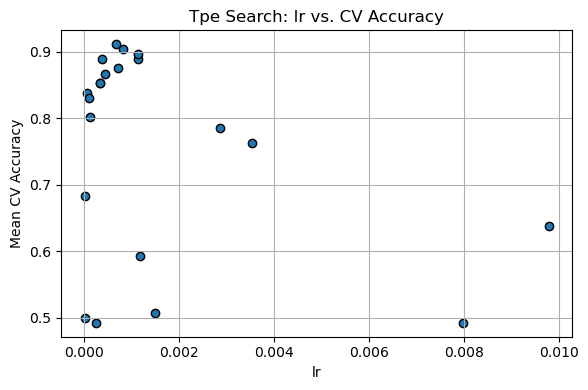

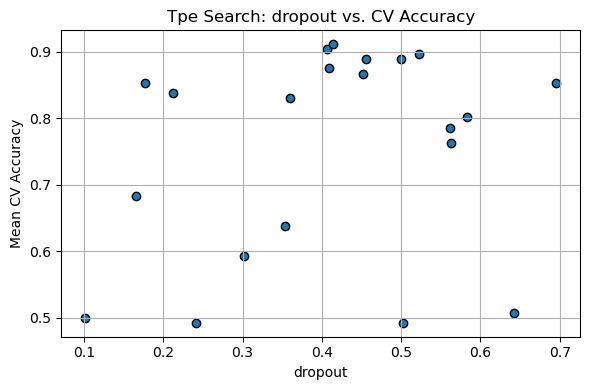

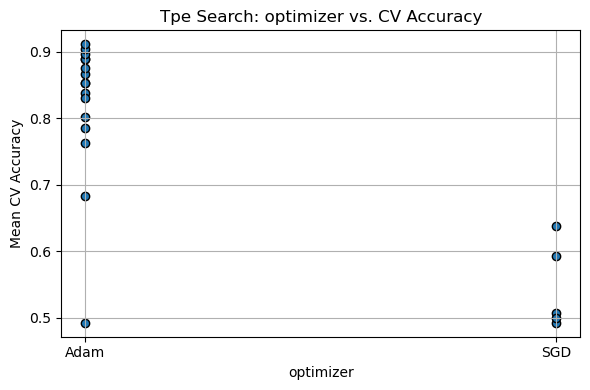

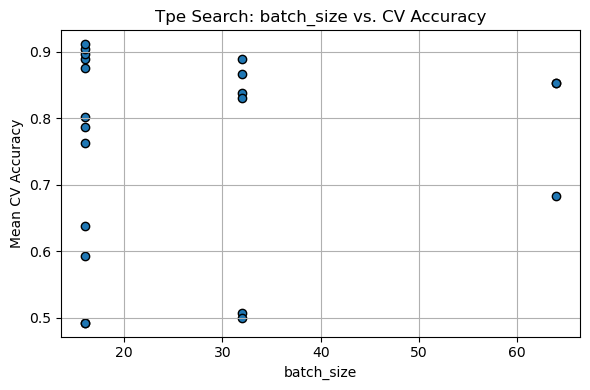

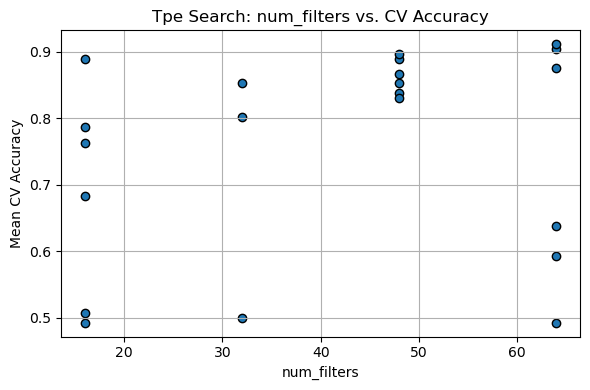


[Cell 2] Plotting validation accuracy curve…


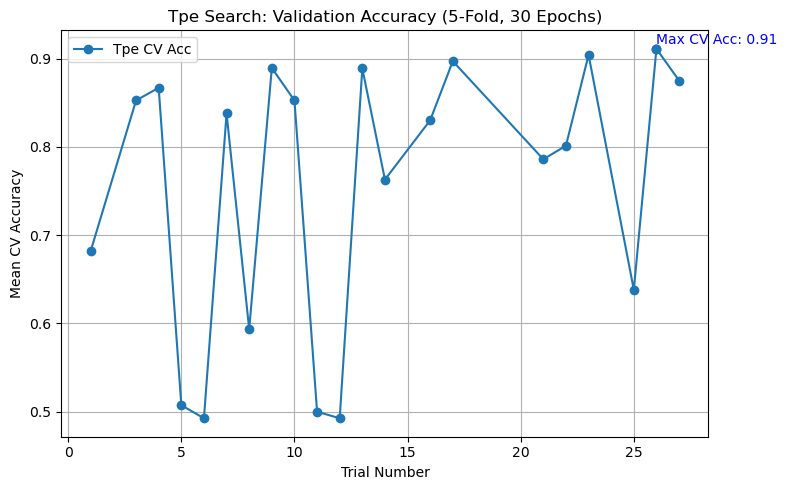


[Cell 2] Plotting validation loss curve…


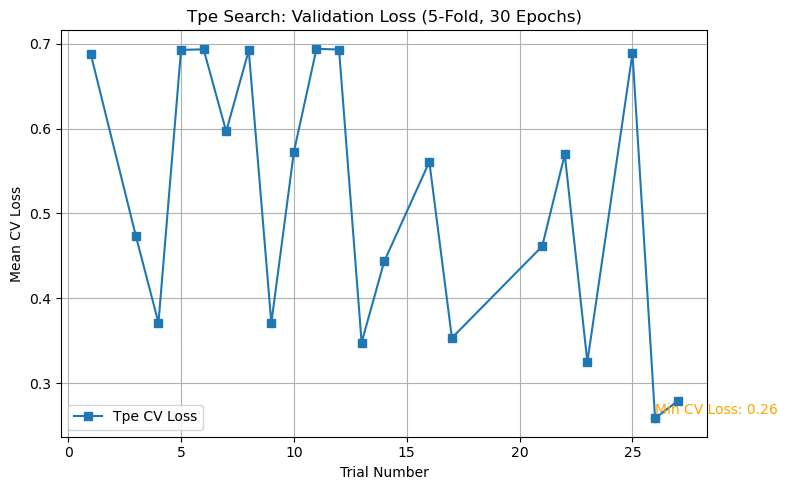


[Cell 2] Best‐so‐far TPE trial #26 | Hyperparams={'lr': 0.000671915588908946, 'dropout': 0.4144857253848475, 'optimizer': 'Adam', 'batch_size': 16, 'num_filters': 64} | CV Acc=0.9111 | CV Loss=0.2585


KeyboardInterrupt: 

In [15]:
# Cell 2: Plot validation curves & retrain the best‐so‐far model on full data

# 1) Create plots/{SEARCH_METHOD} directory if it doesn’t exist (in case Cell 0 wasn’t re‐run)
os.makedirs(f"plots/{SEARCH_METHOD}", exist_ok=True)

print("[Cell 2] Loading the saved study from disk…")
study_name = f"{SEARCH_METHOD.lower()}_search"
study = optuna.load_study(
    study_name=study_name,
    storage=STORAGE_URL
)

# 2a) Print all trials with their hyperparameters, CV accuracy & CV loss
print(f"\n{SEARCH_METHOD.upper()} Search trial summary:")
for t in study.trials:
    params = t.params
    acc    = t.value if t.value is not None else "N/A"
    loss   = t.user_attrs.get("mean_cv_loss", "N/A")
    print(f"  Trial #{t.number:2d} | Params={params} | CV Acc={acc} | CV Loss={loss}")

# 2b) Extract only the completed trials (i.e. t.value is not None)
valid_trials   = [t for t in study.trials if t.value is not None]
trial_nums     = [t.number for t in valid_trials]
trial_accs     = [t.value  for t in valid_trials]
trial_losses   = [t.user_attrs.get("mean_cv_loss", np.nan) for t in valid_trials]

# 2c) Scatter-plots: each hyperparameter versus CV accuracy
print(f"\n[Cell 2] Plotting scatter‐plots of {SEARCH_METHOD.upper()} hyperparameters vs. CV accuracy…")
param_names = list(study.best_params.keys())
for param in param_names:
    x_vals = [t.params[param] for t in valid_trials]
    y_vals = [t.value           for t in valid_trials]
    plt.figure(figsize=(6, 4))
    plt.scatter(x_vals, y_vals, marker='o', edgecolor='k')
    plt.xlabel(param)
    plt.ylabel("Mean CV Accuracy")
    plt.title(f"{SEARCH_METHOD.capitalize()} Search: {param} vs. CV Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/scatter_{SEARCH_METHOD.lower()}_{param}.png", dpi=300)
    plt.show()

# 2d) Plot validation-accuracy curve (CV accuracy vs. trial number)
print("\n[Cell 2] Plotting validation accuracy curve…")
plt.figure(figsize=(8, 5))
plt.plot(trial_nums, trial_accs, marker='o', label=f"{SEARCH_METHOD.capitalize()} CV Acc")
if trial_accs:
    best_idx = trial_nums[np.argmax(trial_accs)]
    best_val = max(trial_accs)
    plt.scatter(best_idx, best_val, color='blue')
    plt.text(best_idx, best_val + 0.005, f"Max CV Acc: {best_val:.2f}", color='blue')
plt.xlabel("Trial Number")
plt.ylabel("Mean CV Accuracy")
plt.title(f"{SEARCH_METHOD.capitalize()} Search: Validation Accuracy ({CV_FOLDS}-Fold, {CV_EPOCHS} Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/{VAL_CURVES_FILENAME}", dpi=300)
plt.show()

# 2e) Plot validation-loss curve (CV loss vs. trial number)
print("\n[Cell 2] Plotting validation loss curve…")
plt.figure(figsize=(8, 5))
plt.plot(trial_nums, trial_losses, marker='s', label=f"{SEARCH_METHOD.capitalize()} CV Loss")
if trial_losses:
    best_loss_idx = trial_nums[np.nanargmin(trial_losses)]
    best_loss_val = min([v for v in trial_losses if not np.isnan(v)])
    plt.scatter(best_loss_idx, best_loss_val, color='orange')
    plt.text(best_loss_idx, best_loss_val + 0.005, f"Min CV Loss: {best_loss_val:.2f}", color='orange')
plt.xlabel("Trial Number")
plt.ylabel("Mean CV Loss")
plt.title(f"{SEARCH_METHOD.capitalize()} Search: Validation Loss ({CV_FOLDS}-Fold, {CV_EPOCHS} Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/{VAL_LOSS_CURVES_FILENAME}", dpi=300)
plt.show()

# 3) Retrain the best-so-far trial on the full training set and plot its learning curves
criterion_final = nn.CrossEntropyLoss()

def build_model_and_optimizer(params):
    model = CNN(num_filters=params["num_filters"], dropout=params["dropout"]).to(DEVICE)
    optimizer = (
        optim.Adam(model.parameters(), lr=params["lr"])
        if params["optimizer"] == "Adam"
        else optim.SGD(model.parameters(), lr=params["lr"])
    )
    return model, optimizer

best_trial   = study.best_trial
best_params  = best_trial.params
best_cv_acc  = best_trial.value
best_cv_loss = best_trial.user_attrs.get("mean_cv_loss", float("nan"))

print(
    f"\n[Cell 2] Best‐so‐far {SEARCH_METHOD.upper()} trial #{best_trial.number} | "
    f"Hyperparams={best_params} | CV Acc={best_cv_acc:.4f} | CV Loss={best_cv_loss:.4f}"
)

model_best, opt_best = build_model_and_optimizer(best_params)
train_loader_best = DataLoader(
    train_dataset,
    batch_size=best_params["batch_size"],  # use tuned batch_size
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=best_params["batch_size"],  # also use tuned batch_size on test if desired
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

NUM_EPOCHS_FINAL = 40

print(f"[Cell 2] Training {SEARCH_METHOD.capitalize()}-best model on full training set…")
best_train_losses, best_train_accs, best_test_losses, best_test_accs = train_full_model(
    model_best,
    train_loader_best,
    test_loader,
    criterion_final,
    opt_best,
    DEVICE,
    NUM_EPOCHS_FINAL
)

epochs_final = np.arange(1, NUM_EPOCHS_FINAL + 1)
print("[Cell 2] Plotting learning curves for the best-so-far model…")
plot_learning_curves(
    epochs_final,
    best_train_accs,
    best_test_accs,
    best_train_losses,
    best_test_losses,
    acc_title=f"{SEARCH_METHOD.capitalize()} Best Model: Train & Test Accuracy per Epoch",
    loss_title=f"{SEARCH_METHOD.capitalize()} Best Model: Train & Test Loss per Epoch",
    acc_filepath=f"{PLOTS_DIR}/best_{SEARCH_METHOD.lower()}_learning_curve.png",
    loss_filepath=f"{PLOTS_DIR}/best_{SEARCH_METHOD.lower()}_loss_curve.png"
)
